In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

In [77]:
# nyc = data[data['entity'] == 'New York-New York City'].drop(columns = 'cases')
data['incremental_cases'] = data['incremental_cases'].astype('int')
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['stay_at_home_announced'] = data['stay_at_home_announced'].map({'yes':1, 'no':0})
data['stay_at_home_effective'] = data['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static

static_check(data)
data = data.loc[:, non_static].drop(columns = 'station_name').rename(columns = {'date':'ds', 'incremental_cases':'y'})

train = data.iloc[:230, :]
test = data.iloc[230:, :]

In [36]:
data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]
nyc = data[data['entity'] == 'New York-New York City'].drop(columns = 'cases')
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc['stay_at_home_announced'] = nyc['stay_at_home_announced'].map({'yes':1, 'no':0})
nyc['stay_at_home_effective'] = nyc['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static


nyc = nyc.loc[:, non_static].rename(columns = {'date':'ds', 'incremental_cases':'y'})


testnyc = nyc.iloc[230:, :]

In [37]:
data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]
la = data[data['entity'] == 'California-Los Angeles'].drop(columns = 'cases')
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")
la['stay_at_home_announced'] = la['stay_at_home_announced'].map({'yes':1, 'no':0})
la['stay_at_home_effective'] = la['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static


la = la.loc[:, non_static].rename(columns = {'date':'ds', 'incremental_cases':'y'})


testla = la.iloc[230:, :]

In [38]:
data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]
cook = data[data['entity'] == 'Illinois-Cook'].drop(columns = 'cases')
cook['incremental_cases'] = cook['incremental_cases'].astype('int')
cook['date'] = pd.to_datetime(cook['date'], format="%Y-%m-%d")
cook['stay_at_home_announced'] = cook['stay_at_home_announced'].map({'yes':1, 'no':0})
cook['stay_at_home_effective'] = cook['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static


cook = cook.loc[:, non_static].rename(columns = {'date':'ds', 'incremental_cases':'y'})


testcook = cook.iloc[230:, :]

In [39]:
data.columns

Index(['date', 'cases', 'stay_at_home_announced', 'stay_at_home_effective',
       'total_population', 'area_sqmi', 'population_density_per_sqmi',
       'percent_fair_or_poor_health',
       'average_number_of_physically_unhealthy_days',
       'average_number_of_mentally_unhealthy_days',
       ...
       'thunder', 'tornado', 'mean_temp_3d_avg', 'max_temp_3d_avg',
       'min_temp_3d_avg', 'dewpoint_3d_avg', 'date_stay_at_home_announced',
       'date_stay_at_home_effective', 'entity', 'incremental_cases'],
      dtype='object', length=134)

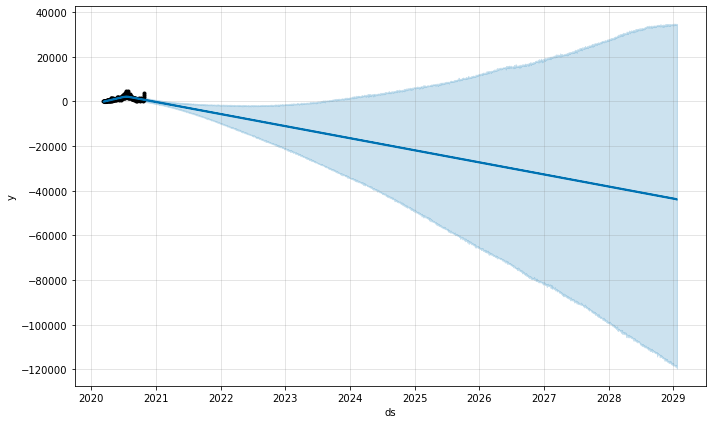

In [81]:
# baseline model
model_baseline = Prophet()
model_baseline.fit(train)

future_baseline = model_baseline.make_future_dataframe(periods=3010)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

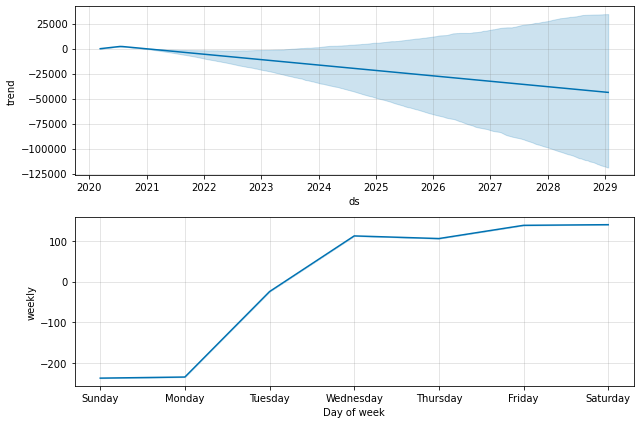

In [82]:
model_baseline.plot_components(forecast_baseline);

In [83]:
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

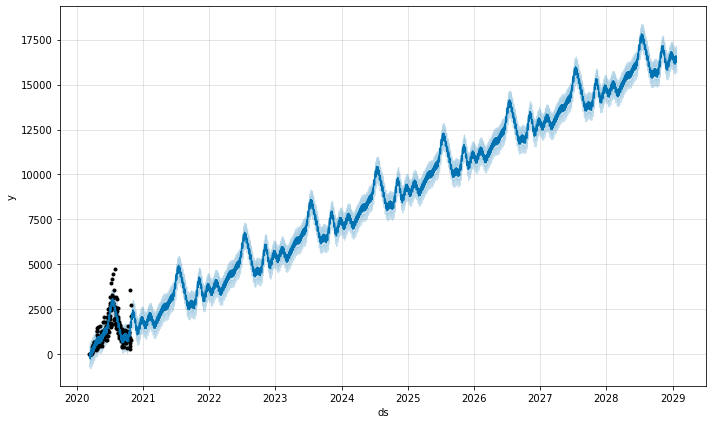

In [84]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_season.fit(train)
future_season = model_season.make_future_dataframe(periods=3010)
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

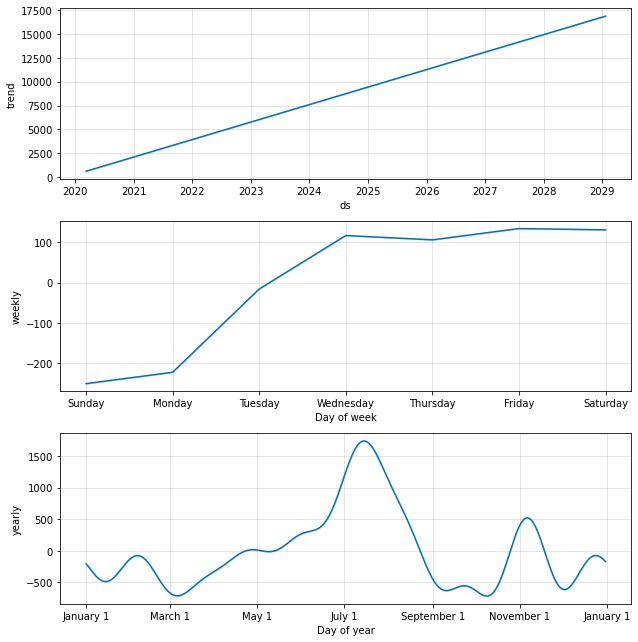

In [85]:
model_season.plot_components(forecast_season);

In [86]:
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
r2 = r2_score(test.y, forecast_season.tail(3010).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':forecast_season.tail(3010).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [69]:

train = train.ffill()

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)

In [70]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced
3230,2020-12-04,1
3231,2020-12-04,1
3232,2020-12-04,1
3233,2020-12-04,1
3234,2020-12-04,1
3235,2020-12-04,1
3236,2020-12-04,1
3237,2020-12-04,1
3238,2020-12-04,1
3239,2020-12-04,1


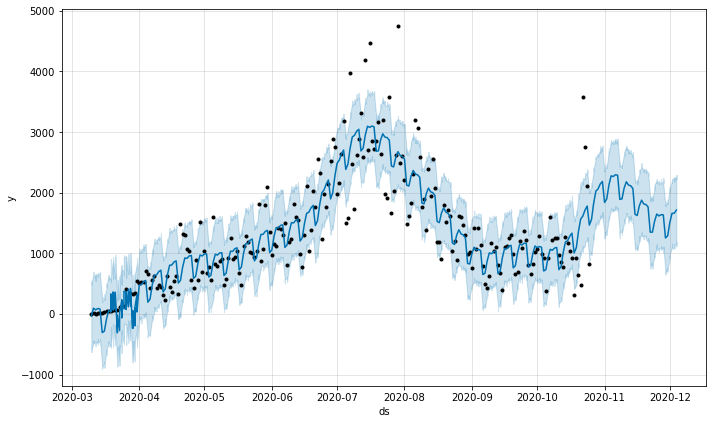

In [71]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

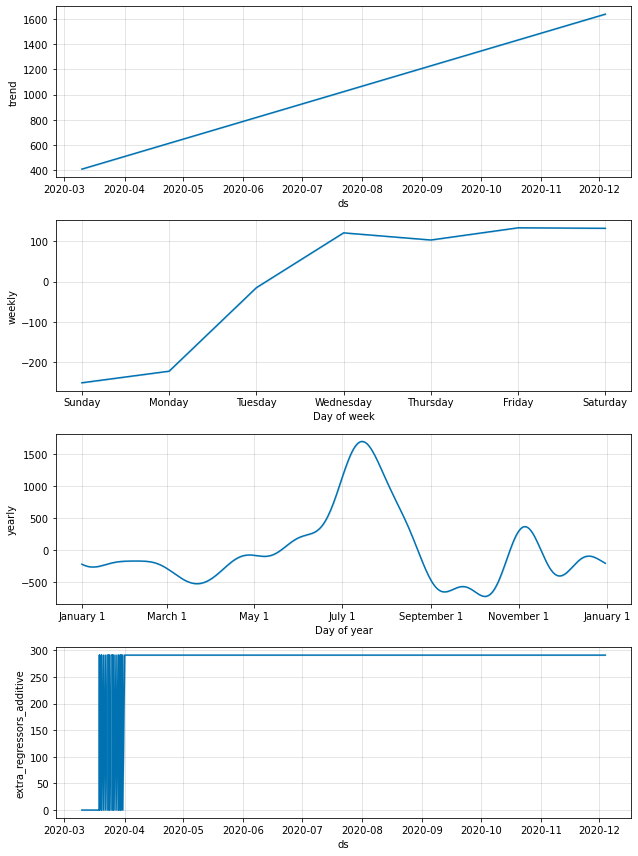

In [72]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [73]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-3010:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 1158.7552966972382
The MAPE for the multivariate model is 0.5058678684530687


In [74]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-3010:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

ValueError: Found input variables with inconsistent numbers of samples: [3010, 40]

In [75]:
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_multivariate.add_regressor('stay_at_home_effective', standardize=False)
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)
future_multivariate = model_multivariate.make_future_dataframe(periods=40)
future_multivariate = pd.merge(future_multivariate, nyc[['ds', 'stay_at_home_effective', 'stay_at_home_announced']], on='ds', how='inner')
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(10)

KeyError: "None of [Index(['ds', 'stay_at_home_effective', 'stay_at_home_announced'], dtype='object')] are in the [columns]"

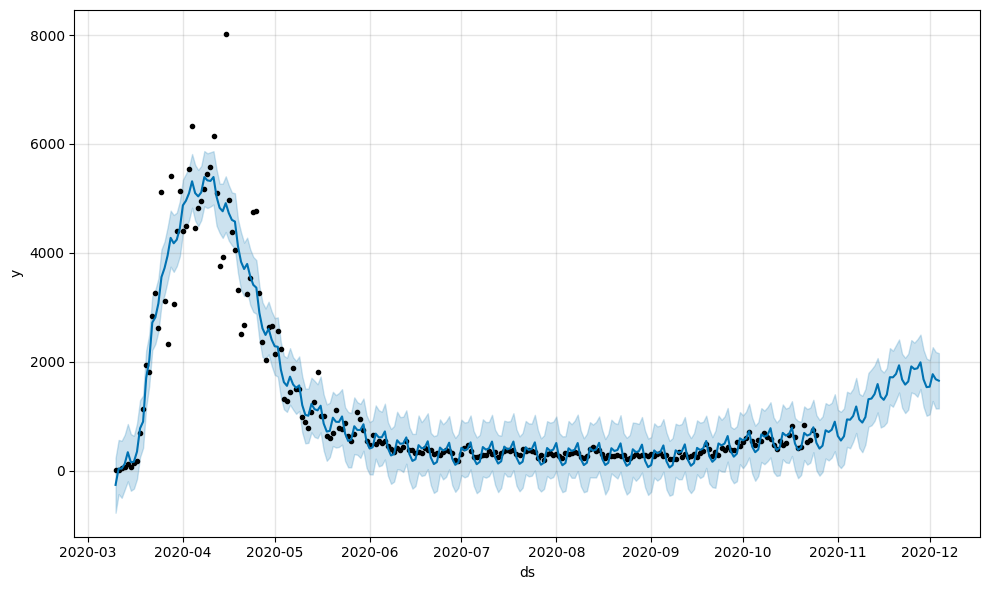

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 375.5247849979175
The MAPE for the multivariate model is 0.19904716786635798


0.3966835223758527


<Axes: xlabel='date'>

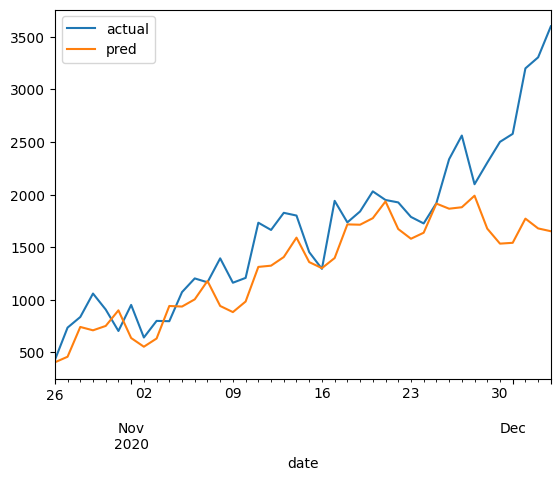

In [ ]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [32]:
non_static_col = ['stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for i in non_static_col:
  model_multivariate.add_regressor(i, standardize=False)
model_multivariate.fit(train)

In [33]:
non_static_col.append('ds')

In [34]:
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, nyc[non_static_col], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced,stay_at_home_effective,mean_temp,min_temp,max_temp,dewpoint,sea_level_pressure,visibility,wind_speed,...,fog,rain,snow,hail,thunder,tornado,mean_temp_3d_avg,max_temp_3d_avg,min_temp_3d_avg,dewpoint_3d_avg
260,2020-11-25,1,1,49.6,42.1,55.0,36.0,1027.8,10.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.600000,59.633333,43.700000,39.100000
261,2020-11-26,1,1,58.8,46.9,64.9,51.4,1018.1,9.5,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,54.733333,61.600000,46.700000,44.700000
262,2020-11-27,1,1,55.8,51.1,64.9,46.7,1017.4,10.0,4.4,...,0.0,0.0,0.0,0.0,0.0,0.0,55.800000,64.600000,49.333333,45.700000
263,2020-11-28,1,1,52.8,50.0,64.0,39.0,1015.6,10.0,4.2,...,0.0,0.0,0.0,0.0,0.0,0.0,52.366667,62.633333,48.033333,39.100000
264,2020-11-29,1,1,48.5,43.0,59.0,31.6,1020.4,10.0,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,52.333333,61.866667,47.666667,39.666667
265,2020-11-30,1,1,55.7,50.0,62.6,48.4,1010.9,8.0,8.4,...,0.0,1.0,0.0,0.0,0.0,0.0,52.400000,61.233333,45.333333,42.066667
266,2020-12-01,1,1,53.0,43.0,62.1,46.2,1001.3,9.8,10.5,...,0.0,1.0,0.0,0.0,0.0,0.0,49.933333,61.233333,43.633333,41.366667
267,2020-12-02,1,1,41.1,37.9,59.0,29.5,1012.9,10.0,15.7,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333
268,2020-12-03,1,1,41.7,36.0,52.0,27.9,1022.2,10.0,9.8,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333
269,2020-12-04,1,1,41.7,36.0,52.0,27.9,1022.2,10.0,9.8,...,0.0,0.0,0.0,0.0,0.0,0.0,45.266667,57.700000,38.966667,34.533333


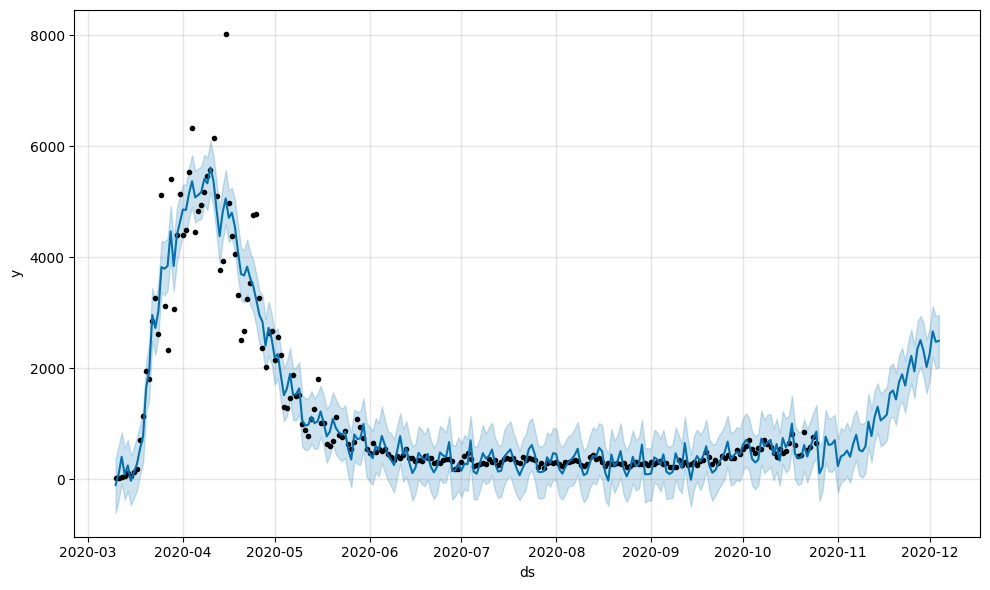

In [35]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [36]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 434.4428561951416
The MAPE for the multivariate model is 0.3064411040431297


0.5365234797667363


<Axes: xlabel='date'>

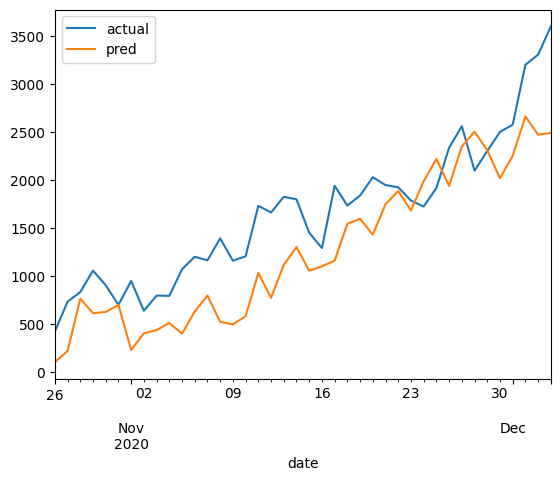

In [37]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('stay_at_home_announced', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

0                           COVID
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5     Independence Day (observed)
6                       Labor Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
dtype: object

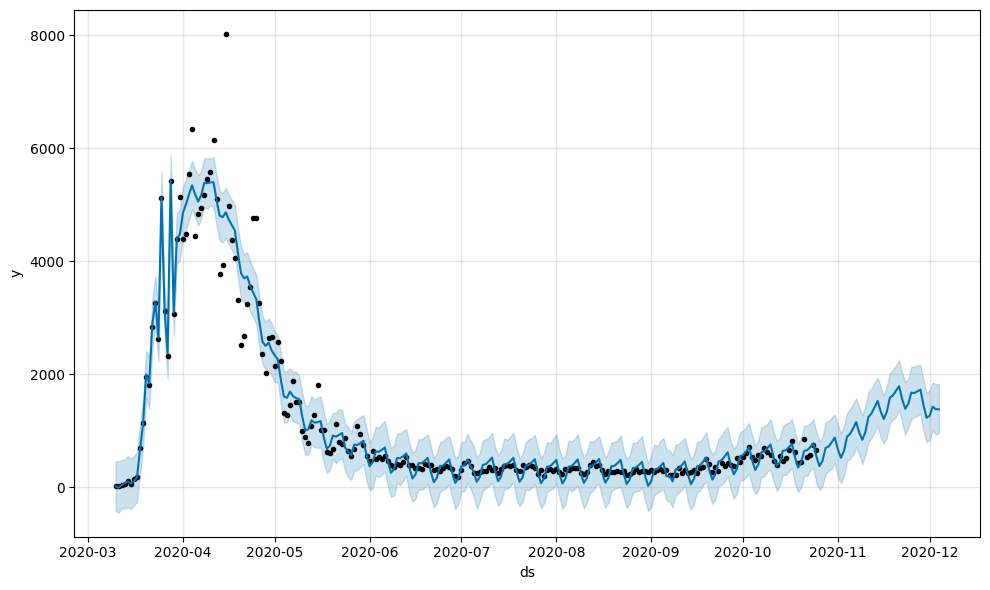

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=40)

# Append the regressor values
future_holiday = pd.merge(future_holiday, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 828.5121380476444
The MAPE for the holiday/event model is 0.3126717216948625


In [ ]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('max_temp', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(nyc)

ValueError: Found NaN in column 'max_temp'

In [ ]:


# Assuming you have a DataFrame 'df' with timestamp, target variable, and related variables
# df = ...

# Separate target variable and related variables
target_variable = df[['timestamp', 'target_variable']]
related_variable_1 = df[['timestamp', 'related_variable_1']]
related_variable_2 = df[['timestamp', 'related_variable_2']]

# Prepare target variable DataFrame
target_variable.columns = ['ds', 'y']

# Create and fit Prophet model for target variable
model_target_variable = Prophet()
model_target_variable.fit(target_variable)

# Prepare related variable DataFrames
related_variable_1.columns = ['ds', 'y']
related_variable_2.columns = ['ds', 'y']

# Create and fit Prophet models for related variables
model_related_variable_1 = Prophet()
model_related_variable_1.fit(related_variable_1)

model_related_variable_2 = Prophet()
model_related_variable_2.fit(related_variable_2)

# Make forecasts
future_target_variable = model_target_variable.make_future_dataframe(periods=30)
forecast_target_variable = model_target_variable.predict(future_target_variable)

future_related_variable_1 = model_related_variable_1.make_future_dataframe(periods=30)
forecast_related_variable_1 = model_related_variable_1.predict(future_related_variable_1)

future_related_variable_2 = model_related_variable_2.make_future_dataframe(periods=30)
forecast_related_variable_2 = model_related_variable_2.predict(future_related_variable_2)

# Further processing and integration of forecasts as needed
